# Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.metrics import AUC
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
%load_ext tensorboard

2023-10-13 15:43:38.552652: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!rm -rf ./logs/

# Loading Dataset

In [3]:
source_path = '.'
train_directory = os.path.join(source_path, 'CheXpert-v1.0/train')
validation_directory = os.path.join(source_path, 'CheXpert-v1.0/valid')

print(f"There are {len(os.listdir(train_directory))}")
print(f"There are {len(os.listdir(validation_directory))}")

There are 64540
There are 200


In [4]:
# Load train and valid labels
train_df = pd.read_csv(os.path.join(source_path, 'CheXpert-v1.0/train.csv'))
valid_df = pd.read_csv(os.path.join(source_path, 'CheXpert-v1.0/valid.csv'))

# Load training and validation image paths
train_image_paths = [source_path + '/' + path for path in train_df['Path']]
valid_image_paths = [source_path + '/' + path for path in valid_df['Path']]
# print(train_df.head())     # printing first five rows of the file
# print(train_df.columns)
# print(valid_df.head())     # printing first five rows of the file
# print(valid_df.columns)

# Create TensorFlow tensors from image paths
train_image_paths = tf.constant(train_image_paths)
valid_image_paths = tf.constant(valid_image_paths)

2023-10-13 15:43:44.733075: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30289 MB memory:  -> device: 0, name: Tesla V100-SXM3-32GB, pci bus id: 0000:57:00.0, compute capability: 7.0


# Creating DataFrames

In [5]:
train_df = train_df[['Path','Frontal/Lateral','Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']]
print(train_df.head())     # printing first five rows of the file
# print(train_df.columns)

                                                Path Frontal/Lateral  \
0  CheXpert-v1.0/train/patient00001/study1/view1_...         Frontal   
1  CheXpert-v1.0/train/patient00002/study2/view1_...         Frontal   
2  CheXpert-v1.0/train/patient00002/study1/view1_...         Frontal   
3  CheXpert-v1.0/train/patient00002/study1/view2_...         Lateral   
4  CheXpert-v1.0/train/patient00003/study1/view1_...         Frontal   

   Cardiomegaly  Edema  Consolidation  Atelectasis  Pleural Effusion  
0           NaN    NaN            NaN          NaN               NaN  
1          -1.0   -1.0           -1.0         -1.0              -1.0  
2           NaN    NaN           -1.0          NaN               NaN  
3           NaN    NaN           -1.0          NaN               NaN  
4           NaN    1.0            NaN          NaN               NaN  


In [6]:
valid_df = valid_df[['Path','Frontal/Lateral','Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']]
# print(valid_df.head())     # printing first five rows of the file
# print(valid_df.columns)

# Train and Valid Labels

In [7]:
train_df_UOnes = train_df.replace(-1,1).fillna(0)
print(len(train_df_UOnes))
train_labels = np.array(train_df_UOnes.drop(['Path', 'Frontal/Lateral'], axis=1))

223414


In [8]:
valid_df_UOnes = valid_df.fillna(0)
print(len(valid_df_UOnes))
valid_labels = np.array(valid_df_UOnes.drop(['Path', 'Frontal/Lateral'], axis=1))

234


# Image Preprocessing

In [9]:
from tqdm import tqdm
from keras.preprocessing import image

#training images preprocessing
SIZE = 320

# Define a custom preprocessing function
def preprocess_image(image_path, label):
    # Read the image file
    image = tf.io.read_file(image_path)
    # Decode the image from bytes to a tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize the image to a fixed size
    image = tf.image.resize(image, [SIZE, SIZE])
    # Normalize pixel values to be in the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


# Prepare the data pipeline by setting batch size & buffer size using tf.data 

In [10]:
# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_image_paths, valid_labels))

In [11]:
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE

# Apply preprocessing function to the datasets
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

# Visualize Sample Image

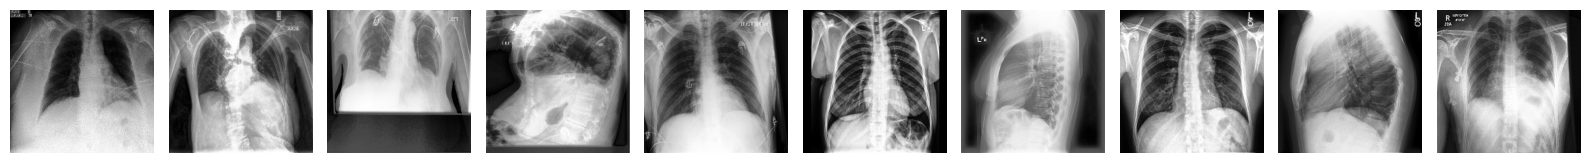

In [12]:
# Plot a sample of 10 original images
fig, axes = plt.subplots(1, 10, figsize=(16, 15))  # Adjust the figsize as needed
axes = axes.flatten()

for i, (image, label) in enumerate(train_ds.take(10)):
    ax = axes[i]
    ax.imshow(image.numpy())  # Select the first image from the batch
    ax.set_axis_off()

plt.tight_layout()
plt.show()

# Augementation

In [13]:
import tensorflow_datasets as tfds
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(
        height_factor=(-0.05, -0.15),
        width_factor=(-0.05, -0.15)),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
])

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
def prepare(ds, shuffle=False, augment=False):
    if shuffle:
        ds = ds.shuffle(1000)

    ds = ds.batch(batch_size)
    ds = ds.cache()

    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    return ds.prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
valid_ds = prepare(valid_ds)

# Visualize Augmented Images

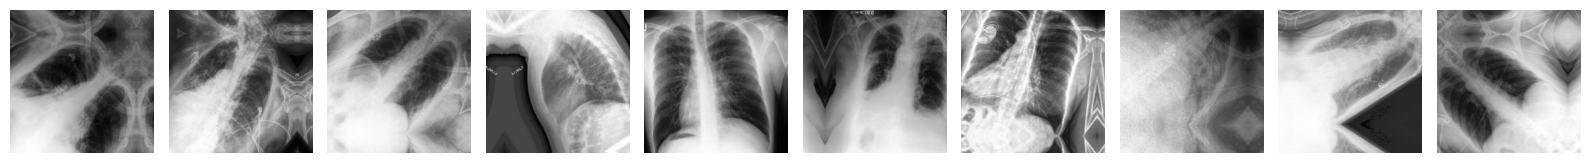

2023-10-13 15:44:04.109650: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6815054746170761219
2023-10-13 15:44:04.109693: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 17069329599193292339
2023-10-13 15:44:04.109703: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 13833124933974168384
2023-10-13 15:44:04.275713: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [16]:
import matplotlib.pyplot as plt

# Define a function to plot sample images
def plot_sample_images(dataset, num_samples=10):
    # Create an iterator for the dataset
    iterator = iter(dataset)

    # Get the next batch of images and labels
    sample_images, sample_labels = next(iterator)

    # Plot the sample images
    fig, axes = plt.subplots(1, num_samples, figsize=(16, 15))
    axes = axes.flatten()

    for i in range(num_samples):
        img = sample_images[i]
        ax = axes[i]
        ax.imshow(img.numpy())  # Convert TensorFlow tensor to NumPy array for plotting
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

# Visualize sample images from the training dataset
plot_sample_images(train_ds, num_samples=10)


# Build the Model

In [17]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications.densenet import DenseNet121
import tensorflow as tf

def create_model():
    model = tf.keras.models.Sequential()
    pre_trained_model = tf.keras.applications.densenet.DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=(320, 320, 3)
    )

    for layer in pre_trained_model.layers:
        layer.trainable = False

    model.add(pre_trained_model)
    model.add(GlobalAveragePooling2D(input_shape=(1024, 1, 1)))
    model.add(Dense(2048, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(tf.keras.layers.Dense(units=5, activation='sigmoid'))
    
#     model.add(tf.keras.layers.Flatten())
#     model.add(tf.keras.layers.Dense(units = 512, activation = 'relu'))
#     model.add(tf.keras.layers.Dense(units = 5, activation = 'sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999),
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy', tf.keras.metrics.AUC(multi_label=True, num_labels=5)])

    return model

# Train the Model

In [18]:
import time

def create_callbacks():
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    checkpoint_dir = "logs/fit/uonescheckpoint"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    class SaveCheckpointCallback(tf.keras.callbacks.Callback):
        def __init__(self, checkpoint_dir, save_interval):
            super(SaveCheckpointCallback, self).__init__()
            self.checkpoint_dir = checkpoint_dir
            self.save_interval = save_interval
            self.iteration = 0

        def on_batch_end(self, batch, logs=None):
            self.iteration += 1
            if self.iteration % self.save_interval == 0:
                model_checkpoint = os.path.join(self.checkpoint_dir, f"model_checkpoint_{self.iteration}.h5")
                self.model.save(model_checkpoint)
                print(f"Saved checkpoint at iteration {self.iteration} to {model_checkpoint}")

    save_interval = 4800  # Adjust this as needed
    checkpoint_callback = SaveCheckpointCallback(checkpoint_dir, save_interval)
    
    return [checkpoint_callback, tensorboard_callback]

In [26]:
trained_models = []

def train(num_runs, train_ds, valid_ds):

    for run in range(num_runs):
        print(f"Run {run + 1} of {num_runs}")

        # Clear previous session to ensure a fresh start for each run
        tf.keras.backend.clear_session()

        model = create_model()
        callbacks = create_callbacks()

        start = time.time()
        history = model.fit(train_ds, epochs=4, validation_data=valid_ds, batch_size=batch_size, callbacks=callbacks, verbose=2)
        print("Total time for run", run + 1, ": ", time.time() - start, "seconds")
        
        trained_models.append(model)

    return trained_models

# Define the number of runs
num_runs = 3
training = train(num_runs, train_ds, valid_ds)

Run 1 of 3
Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved checkpoint at iteration 4800 to logs/fit/uonescheckpoint/model_checkpoint_4800.h5
Saved checkpoint at iteration 9600 to logs/fit/uonescheckpoint/model_checkpoint_9600.h5
13964/13964 - 523s - loss: 0.5656 - binary_accuracy: 0.7238 - auc: 0.6252 - val_loss: 0.5141 - val_binary_accuracy: 0.7607 - val_auc: 0.7267 - 523s/epoch - 37ms/step
Epoch 2/4
Saved checkpoint at iteration 14400 to logs/fit/uonescheckpoint/model_checkpoint_14400.h5
Saved checkpoint at iteration 19200 to logs/fit/uonescheckpoint/model_checkpoint_19200.h5
Saved checkpoint at iteration 24000 to logs/fit/uonescheckpoint/model_checkpoint_24000.h5
13964/13964 - 495s - loss: 0.5276 - binary_accuracy: 0.7474 - auc: 0.6598 - val_loss: 0.4923 - val_binary_accuracy: 0.7735 - val_auc: 0.7790 - 495s/epoch - 35ms/step
Epoch 3/4
Saved checkpoint at iteration 28800 to logs/fit/uonescheckpoint/model_checkpoint_28800.h5
Saved checkpoint at iteration 33600 to logs/fit/uonescheckpoint/model_checkpoint_33600.h5
Saved checkpoint at it

In [ ]:
%tensorboard --logdir logs --port 8885

# Model Evaluate at Every Save Iterations

In [27]:
# Initialize a list to store checkpoint paths for each run
checkpoint_paths_list = []

for model in trained_models:
    checkpoint_paths = []  # Store checkpoint paths for the current model

    # Collect checkpoint paths
    for iteration in range(4800, 52801, 4800): 
        checkpoint_path = f"logs/fit/uonescheckpoint/model_checkpoint_{iteration}.h5"
        checkpoint_paths.append(checkpoint_path)

    checkpoint_paths_list.append(checkpoint_paths)


In [28]:
# Initialize a list to store predictions for each checkpoint
all_predictions = []

# Iterate through the collected checkpoint paths
for checkpoint_paths in checkpoint_paths_list:
    predictions = []  # Store predictions for the current run

    # Load each checkpoint and predict on the validation set
    for checkpoint_path in checkpoint_paths:
        model.load_weights(checkpoint_path)

        # Predict on the validation set
        checkpoint_predictions = model.predict(valid_ds)
        predictions.append(checkpoint_predictions)

    all_predictions.append(predictions)

15/15 [==============================] - 0s 27ms/step


In [30]:
from sklearn.metrics import roc_auc_score

average_auroc_list = []
num_pathologies = 5
iteration_auroc = [] # List of all AUROCs per pathology

for checkpoint_predictions in all_predictions:
    
    for checkpoint_index, checkpoint_prediction in enumerate(checkpoint_predictions):
        checkpoint_auroc_scores = []  # Store AUROC scores for the current model
        
        for pathology_index in range(num_pathologies):
            true_labels = valid_labels[:, pathology_index]
            auroc = roc_auc_score(true_labels, checkpoint_prediction[:, pathology_index])
            checkpoint_auroc_scores.append(auroc)
        
        iteration_auroc.append(checkpoint_auroc_scores)
        
# Calculate the average AUROC across 5 pathologies
average_auroc = np.mean(iteration_auroc, axis = 1)

# Convert iteration_auroc to array
iteration_auroc = np.array(iteration_auroc)

# Calculate the indices that would sort the average AUROC list in descending order
sorted_indices = np.argsort(average_auroc)[::-1]

# Get the top 18 indices
top_indices = sorted_indices[:20]

# Initialize a list to store the corresponding checkpoint_auroc_scores
best_checkpoint_auroc_scores = []

# Extract the checkpoint_auroc_scores for the best 30 averages
for index in top_indices:
    best_checkpoint_auroc_scores.append(iteration_auroc[index])

best_checkpoint_auroc_scores = np.array(best_checkpoint_auroc_scores)

auroc_pathology = np.mean(best_checkpoint_auroc_scores, axis = 0)
print(f"auroc_pathology: {auroc_pathology}")

# Overall AUROC
overall_ave = np.mean(best_checkpoint_auroc_scores)
print(f"overall_ave_AUROC: {overall_ave}")

auroc_pathology: [0.70315822 0.82727807 0.82106136 0.76306006 0.80267674]
overall_ave_AUROC: 0.7834468907449526
